In [326]:
# libraries
import csv
from IPython.display import clear_output
from matplotlib import pyplot as plt
import numpy as np
import os
from scipy.io import loadmat
from scipy.stats import mannwhitneyu
from sklearn import linear_model
from sklearn.decomposition import PCA
from sklearn.metrics import roc_auc_score, roc_curve
import sys
import time
# directories
muspDir='/home/pboord/Downloads/kaggle/musp'
dataDir=os.path.join(muspDir,'data')
dataSet='train_1'
dataSetPath=os.path.join(dataDir,dataSet)
# Constants
nrCh = 16
nrLowTri = np.tril_indices(nrCh,k=-1)[0].shape[0]

In [572]:
# functions
def sumSq(data):
    return np.sum(np.square(data))/np.prod(data.shape)
def corVector(data):
    corArray = np.corrcoef(data.T)
    return corArray[np.tril_indices(data.shape[1],k=-1)]
def covVector(data):
    data -= np.mean(data,axis=0)
    covArray = np.cov(data.T)
    return covArray[np.tril_indices(data.shape[1],k=-1)]
def yTrue(list0,list1):
    return np.concatenate((np.zeros((len(list0),)),np.ones((len(list2),))),axis=0)
def subjMatClass(dataSetPath):
    matClass = {}
    # mat files in directory
    (_, _, filenames) = os.walk(dataSetPath).next()
    with open(os.path.join(muspDir,'train_and_test_data_labels_safe.csv')) as csvfile:
        reader = csv.DictReader(csvfile)
        for row in reader:
            if row['safe'] and row['image'] in filenames:
                matClass[row['image']] = str.split(row['image'].split('_')[2],'.')[0] == '1'    
    return matClass
def genFeature(featureFn):
    featOut = {}
    loopNr = 0
    for matFile in matClass.keys():
        time0 = time.time()
        loopNr += 1
        try:
            data = loadmat(os.path.join(dataSetPath,matFile))['dataStruct']['data'][0][0,]
        except ValueError:
            del matClass[matFile]
            continue
        # process data
        featOut[matFile] = featureFn(data)
        print(str( (len(matClass) - loopNr)*(time0 - time.time()) ))
        clear_output(wait=True)
    return featOut
def histFeatures(featCor0,featCor1):
    # allow arrays as input (as well as lists)
    featCor0 = list(featCor0)
    featCor1 = list(featCor1)
    bin_edges = np.histogram(featCor0 + featCor1)[1]
    width = 0.5 * (bin_edges[1] - bin_edges[0])
    hist0 = np.histogram(featCor0,bin_edges)[0]
    hist1 = np.histogram(featCor1,bin_edges)[0]
    plt.bar(bin_edges[0:10], hist0.astype(float)/sum(hist0), width, alpha=0.5, color='r', label='0')
    plt.bar(bin_edges[0:10], hist1.astype(float)/sum(hist1), width, align='center', alpha=0.5, color='g', label='1')
    plt.legend(loc='upper right')
    plt.show()
    return
def threshSumSq(ssIn,matIn,sumSqThresh):
    ssOut = []
    matOut = []
    for i in range(0,len(ssIn)):
        if ssIn[i] < sumSqThresh:
            ssOut.append(ssIn[i])
            matOut.append(matIn[i])
    return ssOut,matOut
def invCov(data):
    print data.shape
    mn = np.mean(data,axis=0)
    data -= mn
    cov = np.cov(data.T)
    print 'det of cov:' + '\t' + np.linalg.det(cov)
    iCov = np.linalg.inv(cov)
    return iCov,mn
def mahaSq(data,iCov,mn):
    data -= mn
    mahaSquared = np.einsum('ij,ij->i',np.dot(data,iCov),data)
    return mahaSquared
def cor2and3(data):
    appendOk = 0
    corOut = 0
    goodSamples = np.logical_not(np.all(data == 0,axis=1))
    if goodSamples.sum() != 0:
        appendOk = 1
        data = data[goodSamples,2:4]
        corOut = np.corrcoef(data.T)[0,1]
    return appendOk,corOut
def varExp(data):
    pca = PCA(n_components=2)
    pca.fit(data)
    return pca.explained_variance_ratio_
def plotData(matFile):
    print matFile
    matPath=os.path.join(dataSetPath,matFile)
    data = loadmat(os.path.join(dataSetPath,matFile))['dataStruct']['data'][0][0,]
    goodSamples = np.logical_not(np.all(data == 0,axis=1))
    data = data[goodSamples,:]
    plt.plot(data)
    plt.ylim(-200,200)
    plt.show()
    return data
def plotCorr(matFile):
    data = loadmat(os.path.join(dataSetPath,matFile))['dataStruct']['data'][0][0,]
    goodData = data[np.logical_not(np.all(data == 0,axis=1)),:]
    x = np.corrcoef(goodData.T)
    fig,ax = plt.subplots()
    p = ax.imshow(x,interpolation='nearest',cmap=plt.cm.hot,vmin=-1, vmax=1)
    cb = plt.colorbar(p,shrink=0.5)
    ax.set_xlabel('Ch')
    ax.set_ylabel('Ch')
    ax.set_title(matFile)
    cb.set_label('Corr')
    plt.show()
    return data
def plotRoc(fpr,tpr,auc,rocTitle):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(rocTitle)
    plt.legend(loc="lower right")
    plt.show()
def rocLogReg(X,yTrue):
    logreg = linear_model.LogisticRegression()
    logreg.fit(X,yTrue)
    yPred = logreg.predict(X)
    yPredProb = logreg.predict_proba(X)[:,1]
    auc = roc_auc_score(yTrue, yPredProb)
    fpr, tpr, thresholds = roc_curve(yTrue,yPredProb,pos_label=True)
    print X.shape[1],sum(yTrue == yPred),len(yTrue),float(sum(yTrue == yPred))/len(yTrue), auc
    plotRoc(fpr,tpr,auc,'')
    return auc,yPredProb
def sigFeat(dataFeatures,yTrue):
    pList = []
    for i in range(0,nrLowTri):
        _,p = mannwhitneyu(dataFeatures[np.logical_not(yTrue),i],dataFeatures[yTrue,i])
        pList.append(p)
    return dataFeatures[:,np.asarray(pList) < 0.05/nrLowTri]
def specEdge(data):
    okSamp = int(8*400)
    bin40hz = 40*8
    goodSamples = np.logical_not(np.all(data == 0,axis=1))
    diffGoodSamples = np.diff(np.concatenate(([0],goodSamples.astype(float),[0])))
    okStartEnd = np.where(diffGoodSamples > 0)[0],np.where(diffGoodSamples < 0)[0]
    okLen = okStartEnd[1] - okStartEnd[0]
    okLong = np.asarray(okStartEnd)[:,np.asarray(okLen) > okSamp]
    if okLong.sum() == 0:
        edgeFreq = -1
    else:
        data = data.mean(axis=1)
        data -= data.mean()
        a = np.empty( shape=(0,okSamp) )
        for i in range(0,okLong.shape[1]):
            for j in range(okLong[0,i]+okSamp,okLong[1,i],okSamp):
                a = np.vstack([a,data[j-okSamp:j]])
        b = np.repeat(np.blackman(a.shape[1]).reshape((-1,1)),a.shape[0],axis=1).T
        c = np.multiply(a,b)
        spec40hz = np.mean(np.absolute(np.fft.fft(c,axis=1)),axis=0)[0:bin40hz]
        edgeFreq = np.where(np.diff(np.cumsum(spec40hz) < spec40hz.sum()/2))[0][0]
    return edgeFreq

In [561]:
# make feature dictionaries
ssFeat = {}
corFeat = {}
covFeat = {}
edgeFeat = {}
matClass = subjMatClass(dataSetPath)
loopNr = 0
nrMatAtStart = len(matClass)
for matFile in matClass.keys():
    time0 = time.time()
    loopNr += 1
    try:
        data = loadmat(os.path.join(dataSetPath,matFile))['dataStruct']['data'][0][0,]
    except ValueError:
        del matClass[matFile]
        continue
    goodSamples = np.logical_not(np.all(data == 0,axis=1))
    if np.all(goodSamples == 0):
        del matClass[matFile]
        continue
    else:
        edgeFreq = specEdge(data)
        if edgeFreq < 0:
            del matClass[matFile]
            continue
        else:
            # process data
            ssFeat[matFile] = sumSq(data[goodSamples,:])
            corFeat[matFile] = corVector(data[goodSamples,:])
            covFeat[matFile] = covVector(data[goodSamples,:])
            edgeFeat[matFile] = edgeFreq
    print(str( (nrMatAtStart - loopNr)*(time.time() - time0) ))
    clear_output(wait=True)

0.0


In [393]:
a = range(0,5,2)
a

[0, 2, 4]

In [396]:
137566-134366,okSamp

(3200, 3200)

In [485]:
b.reshape((-1,1)).shape

(3200, 1)

In [489]:
np.blackman(a.shape[1]).reshape((-1,1)).shape

(3200, 1)

In [495]:
b = np.repeat(np.blackman(a.shape[1]).reshape((-1,1)),a.shape[0],axis=1).T.shape

(31, 3200)

In [508]:
bin40hz = 40*8
bin40hz

320

In [521]:
spec40hz = np.mean(np.absolute(np.fft.fft(c,axis=1)),axis=0)[0:bin40hz]
np.where(np.diff(np.cumsum(spec40hz) < spec40hz.sum()/2))[0][0]

149

(19, 3200)
(19, 3200)
146
(320,)


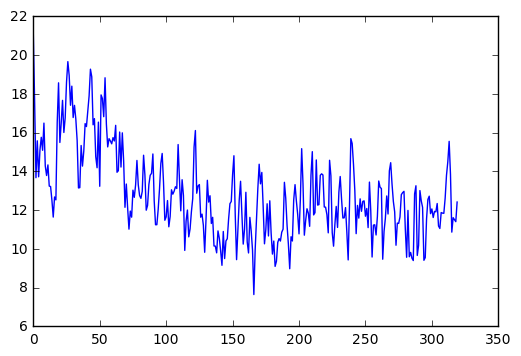

In [543]:
data = loadmat(os.path.join(dataSetPath,'1_867_0.mat'))['dataStruct']['data'][0][0,]
# #data = loadmat(os.path.join(dataSetPath,'1_1114_0.mat'))['dataStruct']['data'][0][0,]
# #data = loadmat(os.path.join(dataSetPath,'1_951_0.mat'))['dataStruct']['data'][0][0,]
# #data = loadmat(os.path.join(dataSetPath,'1_867_0.mat'))['dataStruct']['data'][0][0,]
# #data = loadmat(os.path.join(dataSetPath,'1_136_1.mat'))['dataStruct']['data'][0][0,]
# #data = loadmat(os.path.join(dataSetPath,'1_106_1.mat'))['dataStruct']['data'][0][0,]
# #data = loadmat(os.path.join(dataSetPath,'1_138_1.mat'))['dataStruct']['data'][0][0,]

# get segments > 8 sec
okSamp = int(8*400)
bin40hz = 40*8
goodSamples = np.logical_not(np.all(data == 0,axis=1))
diffGoodSamples = np.diff(np.concatenate(([0],goodSamples.astype(float),[0])))
okStartEnd = np.where(diffGoodSamples > 0)[0],np.where(diffGoodSamples < 0)[0]
okLen = okStartEnd[1] - okStartEnd[0]
okLong = np.asarray(okStartEnd)[:,np.asarray(okLen) > okSamp]
# print okLong
data = data.mean(axis=1)
data -= data.mean()
a = np.empty( shape=(0,okSamp) )
for i in range(0,okLong.shape[1]):
    for j in range(okLong[0,i]+okSamp,okLong[1,i],okSamp):
        a = np.vstack([a,data[j-okSamp:j]])
b = np.repeat(np.blackman(a.shape[1]).reshape((-1,1)),a.shape[0],axis=1).T
print a.shape
print b.shape
c = np.multiply(a,b)
# b = np.array(np.blackman(a.shape[1]).reshape((-1,1))
# b = np.repeat(np.blackman(a.shape[1]).reshape((-1,1)).shape,a.shape[0],axis=1)
spec40hz = np.mean(np.absolute(np.fft.fft(c,axis=1)),axis=0)[0:bin40hz]
fEdge = np.where(np.diff(np.cumsum(spec40hz) < spec40hz.sum()/2))[0][0]
print fEdge
print d.shape
plt.plot(spec40hz.T)
plt.show()

In [544]:
# for matFile in matClass.keys():
#     try:
#         data = loadmat(os.path.join(dataSetPath,matFile))['dataStruct']['data'][0][0,]
#     except ValueError:
#         continue
#     goodSamples = np.logical_not(np.all(data == 0,axis=1))
#     propGood = float(goodSamples.sum())/goodSamples.shape[0]
#     if propGood < 0.5:
#         print propGood, matFile


77 1130 1253 0.901835594573 0.853441483797


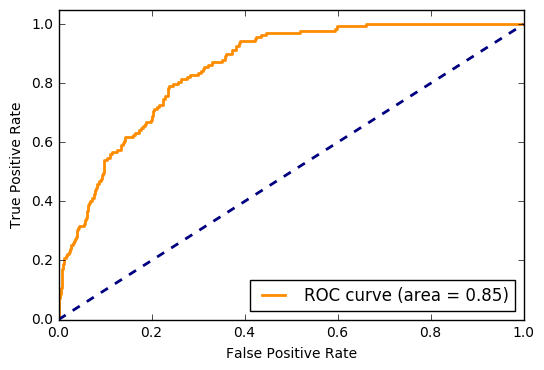

In [584]:
yTrue = []
ssList = []
corList = []
covList = []
edgeList = []
for matFile,preictal in matClass.iteritems():
    yTrue.append(preictal)
    ssList.append(ssFeat[matFile])
    corList.append(corFeat[matFile])
    covList.append(covFeat[matFile])
    edgeList.append(edgeFeat[matFile])
yTrue = np.asarray(yTrue)
ssList = np.asarray(ssList)
corList = np.asarray(corList)
covList = np.asarray(covList)
edgeList = np.asarray(edgeList)
#auc = rocLogReg(ssList.reshape(-1,1),yTrue)
#auc = rocLogReg(sigFeat(corList,yTrue),yTrue)
auc,yPredProb = rocLogReg(sigFeat(covList,yTrue),yTrue)
#auc,yPredProb = rocLogReg(edgeList.reshape(-1,1),yTrue)


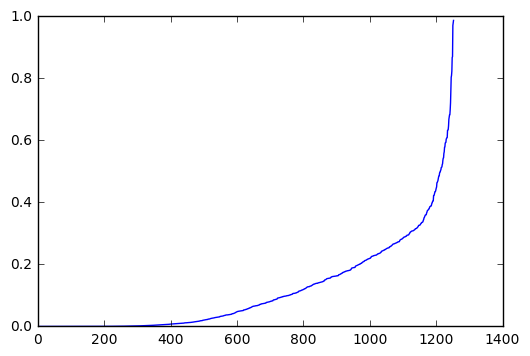

In [585]:
plt.plot(np.sort(yPredProb))
plt.show()

In [ ]:
# Get all valid mat files¶
matClass0,matClass1 = dirMatClassList(dataSetPath)
len(matClass0),len(matClass1)
# Get sumSq for each class
featSumSq0,matSumSq0 = genFeature(sumSq,matClass0)
featSumSq1,matSumSq1 = genFeature(sumSq,matClass1)
# Get data with sumSq < 600
sumSqThresh = 600
sumSqThresh0,matThresh0 = threshSumSq(featSumSq0,matSumSq0,sumSqThresh)
sumSqThresh1,matThresh1 = threshSumSq(featSumSq1,matSumSq1,sumSqThresh)
# Plot sumSq histograms
histFeatures(sumSqThresh0,sumSqThresh1)
# Get corr vector lists
corVec0,matCorVec0 = genFeature(corrVector,matThresh0)
corVec1,matCorVec1 = genFeature(corrVector,matThresh1)

In [3]:
# corVec0,matCorVec0 = genFeature(corrVector,matSumSq0)
# corVec1,matCorVec1 = genFeature(corrVector,matSumSq1)
# PCA of (corVec0 + corVec1)
# Hypothesis: first PC's will separate classes. & avoids problems of maha approach if cov is near singular
pca = PCA(n_components=5)
corVec01 = np.asarray(corVec0+corVec1)
corVec01 -= np.mean(corVec01,axis=0)
pca.fit(corVec01)
pca0 = np.dot(np.asarray(corVec0),pca.components_.T)
pca1 = np.dot(np.asarray(corVec1),pca.components_.T)
i=0
histFeatures(pca0[:,i],pca1[:,i])
# Get maha dist^2 to each class centroid
mahaSq00 = mahaSq(np.asarray(corVec0),iCov0,mn0)
mahaSq01 = mahaSq(np.asarray(corVec0),iCov1,mn1)
mahaSq10 = mahaSq(np.asarray(corVec1),iCov0,mn0)
mahaSq11 = mahaSq(np.asarray(corVec1),iCov1,mn1)
# Plot sumSq histograms
histFeatures(mahaSq00,mahaSq10)
histFeatures(mahaSq11,mahaSq01)
histFeatures(mahaSq00,mahaSq01)
histFeatures(mahaSq11,mahaSq10)
# Get cov vector lists
covVec0,matCovVec0 = genFeature(covVector,matThresh0)
covVec1,matCovVec1 = genFeature(covVector,matThresh1)
pca = PCA(n_components=5)
covVec01 = np.asarray(covVec0+covVec1)
covVec01 -= np.mean(covVec01,axis=0)
pca.fit(covVec01)
pca0 = np.dot(np.asarray(covVec0),pca.components_.T)
pca1 = np.dot(np.asarray(covVec1),pca.components_.T)
i=0
histFeatures(pca0[:,i],pca1[:,i])
# cor cell t-tests

# Get mean / invCov of covVec's
iCov0,mn0 = invCov(np.asarray(covVec0))
iCov1,mn1 = invCov(np.asarray(covVec1))
# Get maha dist^2 to each class centroid
mahaSq00 = mahaSq(np.asarray(covVec0),iCov0,mn0)
mahaSq01 = mahaSq(np.asarray(covVec0),iCov1,mn1)
mahaSq10 = mahaSq(np.asarray(covVec1),iCov0,mn0)
mahaSq11 = mahaSq(np.asarray(covVec1),iCov1,mn1)
# Plot sumSq histograms
histFeatures(mahaSq00,mahaSq10)
histFeatures(mahaSq11,mahaSq01)
histFeatures(mahaSq00,mahaSq01)
histFeatures(mahaSq11,mahaSq10)